### Author: Russell Ault

# This Notebook Contains code for exploring the functionality of the Pytorch Handwriting Recognition Library

## It is clear to me that I need to write interactive code to load a model that we have trained and test it on a validation set, and have it output accuracy and word error rates. 

## The present way that the library is written is clearly not easily conducive to this

## Here are some comments I have about the code and how to improve it:
- In evaluating model accuracy a character by character accuracy is being used, not an edit distance. I need to put character and word error rates into the model. I should include a mean and sd of these parameters.
- I think I need to just run the validation code right now to see what it does.
- I think that the main python module should be refactored to allow its use in other python modules.

# Reproduce Main Functionality in Notebook fashion

In [1]:
from __future__ import print_function
import argparse
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import numpy as np
from warpctc_pytorch import CTCLoss
import os
import utils
import dataset

In [2]:
import models.crnn as crnn

In [3]:
import sys  
stdout = sys.stdout
reload(sys)  
sys.setdefaultencoding('latin-1')
from model_error import cer, wer


#My workaround was that at the top of the script, I import sys, and store sys.stdout in a separate variable, e.g. stdout.
sys.stdout = stdout
print(sys.getdefaultencoding())

latin-1


In [39]:
from model_error import cer, wer

In [5]:
print(3+3)

6


In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--trainroot', required=True, help='path to dataset')
parser.add_argument('--valroot', required=True, help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--imgH', type=int, default=32, help='the height of the input image to network')
parser.add_argument('--imgW', type=int, default=100, help='the width of the input image to network')
parser.add_argument('--nh', type=int, default=256, help='size of the lstm hidden state')
parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.01, help='learning rate for Critic, default=0.00005')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--crnn', default='', help="path to crnn (to continue training)")
parser.add_argument('--alphabet', type=str, default='0123456789abcdefghijklmnopqrstuvwxyz')
parser.add_argument('--experiment', default=None, help='Where to store samples and models')
parser.add_argument('--displayInterval', type=int, default=500, help='Interval to be displayed')
parser.add_argument('--n_test_disp', type=int, default=10, help='Number of samples to display when test')
parser.add_argument('--valInterval', type=int, default=500, help='Interval to be displayed')
parser.add_argument('--saveInterval', type=int, default=500, help='Interval to be displayed')
parser.add_argument('--adam', action='store_true', help='Whether to use adam (default is rmsprop)')
parser.add_argument('--adadelta', action='store_true', help='Whether to use adadelta (default is rmsprop)')
parser.add_argument('--keep_ratio', action='store_true', help='whether to keep ratio for image resize')
parser.add_argument('--random_sample', action='store_true', help='whether to sample the dataset with random sampler')
opt = parser.parse_args()
print(opt)

In [ ]:
if experiment is None:
    experiment = 'expr'
os.system('mkdir {0}'.format(experiment))

### Set variables

In [4]:
trainroot = "/home/ubuntu/russell/nephi/data/lmdb/train"
valroot = "/home/ubuntu/russell/nephi/data/lmdb/val"
batchSize = 64
nh = 256                  # size of the LSTM hidden state
imgW = 100
imgH = 32
ngpu = 1
beta1 = 0.5
lr = 0.0001
workers = 10
keep_ratio = True
adam = True
adadelta = False
n_test_disp = 100

alph_file_dylan = "/home/ubuntu/dylan/nephi/alphabet.txt"
alph_file_russell = "/home/ubuntu/russell/nephi/alphabet.txt"
alphabet = '0123456789abcdefghijklmnopqrstuvwxyzB- EÂ¬Ã¼.RSÅ«J/DHA:K¤¿ZLGFNTPCOVWIM<8d>Ä<81><9f>,<93>È³¶'
#0123456789abcdefghijklmnopqrstuvwxyzW VCGū¬.HM,ILAZ:BTÿSER<BC>JFāP<9F>NDKOȳ<B6>
#<A4><8D>()—̈-<84><93>Q<96>/Y<BE>U<>+  # This is what I got from Dylan's file

untrained_crnn_dylan = "/home/ubuntu/dylan/nephi/expr/netCRNN_1_100.pth"
#less trained 29
lesstrained_crnn_dylan = "/home/ubuntu/dylan/nephi/expr/netCRNN_1000_100.pth"
trained_crnn_russell = "/home/ubuntu/russell/nephi/expr/netCRNN_3870_100.pth"
trained_crnn_dylan = "/home/ubuntu/dylan/nephi/expr/netCRNN_3210_100.pth"

In [5]:
manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  9735


In [6]:
cudnn.benchmark = True
cuda = True

#if torch.cuda.is_available() and not cuda:
#    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

train_dataset = dataset.lmdbDataset(root=trainroot)
sampler = dataset.randomSequentialSampler(train_dataset, batchSize)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchSize, sampler=sampler,
    num_workers=int(workers),
    collate_fn=dataset.alignCollate(imgH=imgH, imgW=imgW, keep_ratio=keep_ratio))

training_eval_set = dataset.lmdbDataset(
    root=trainroot, transform=dataset.resizeNormalize((imgW, imgH))) 
test_dataset = dataset.lmdbDataset(
    root=valroot, transform=dataset.resizeNormalize((imgW, imgH)))   # I have changed this line from the original code

In [7]:
# Load in the two alphabets
alphabet_russell = ''
alphabet_dylan = ''

with open(alph_file_russell, 'r') as myfile:
    alphabet_russell = myfile.read()
with open(alph_file_dylan, 'r') as myfile:
    alphabet_dylan = myfile.read()
    


In [8]:
# Test the dylan ALphabet and model first
alphabet = alphabet_dylan

nclass = len(alphabet) + 1
nc = 1

converter = utils.strLabelConverter(alphabet)
criterion = CTCLoss()

In [9]:
# custom weights initialization called on crnn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
crnn = crnn.CRNN(imgH, nc, nclass, nh)

In [11]:
crnn.apply(weights_init)



CRNN (
  (cnn): Sequential (
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU (inplace)
    (pooling0): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU (inplace)
    (pooling1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (relu2): ReLU (inplace)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU (inplace)
    (pooling2): MaxPool2d (size=(2, 2), stride=(2, 1), dilation=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu4): ReLU (inplace)
    (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), pad

# Based on the above unexpected key error, I will assume that when I try to run the original code with a validation epoch number, I will get the same error

In [12]:
image = torch.FloatTensor(batchSize, 3, imgH, imgH)
text = torch.IntTensor(batchSize * 5)          # RA: I don't understand why the text has this size
length = torch.IntTensor(batchSize)

if cuda:
    crnn.cuda()
    crnn = torch.nn.DataParallel(crnn, device_ids=range(ngpu))
    image = image.cuda()
    criterion = criterion.cuda()

In [13]:
# Load Dylan's pretrained model first
trained_crnn = trained_crnn_dylan
if trained_crnn != '':
    print('loading pretrained model from %s' % trained_crnn)
    crnn.load_state_dict(torch.load(trained_crnn))
print(crnn)

loading pretrained model from /home/ubuntu/dylan/nephi/expr/netCRNN_3210_100.pth
DataParallel (
  (module): CRNN (
    (cnn): Sequential (
      (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu0): ReLU (inplace)
      (pooling0): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU (inplace)
      (pooling1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu2): ReLU (inplace)
      (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU (inplace)
      (pooling2): MaxPool2d (size=(2, 2), stride=(2, 1), dilation=(1, 1))
      (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm4): BatchNorm2d(5

In [14]:
image = Variable(image)
text = Variable(text)
length = Variable(length)

# loss averager
loss_avg = utils.averager()

# setup optimizer
if adam:
    optimizer = optim.Adam(crnn.parameters(), lr=lr,
                           betas=(beta1, 0.999))
elif adadelta:
    optimizer = optim.Adadelta(crnn.parameters(), lr=lr)
else:
    optimizer = optim.RMSprop(crnn.parameters(), lr=lr)

# Here is where I will test out the code.

### First order of business is to see what val outputs currently on these pretrained models using the test set.
### Then add word and character error rate and a way to calculate mean and standard deviation of them.

In [25]:
def val(net, dataset, criterion, max_iter=100):
    print('Start val')

    for p in crnn.parameters():
        p.requires_grad = False

    net.eval()
    data_loader = torch.utils.data.DataLoader(
        dataset, shuffle=True, batch_size=batchSize, num_workers=int(workers))
    val_iter = iter(data_loader)

    i = 0
    n_correct = 0
    loss_avg = utils.averager()
    
    image_count = 0
    
    # Character and word error rate lists
    char_error = []
    w_error = []

    max_iter = min(max_iter, len(data_loader))
    #max_iter = len(data_loader)
    for i in range(max_iter):
        data = val_iter.next()
        i += 1
        cpu_images, cpu_texts = data
        batch_size = cpu_images.size(0)
        image_count = image_count + batch_size
        utils.loadData(image, cpu_images)
        t, l = converter.encode(cpu_texts)
        utils.loadData(text, t)
        utils.loadData(length, l)

        preds = crnn(image)
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        cost = criterion(preds, text, preds_size, length) / batch_size
        loss_avg.add(cost)
        
        
        # RA: While I am not sure yet, it looks like a greedy decoder and not beam search is being used here
        # Also, a simple character by character accuracy is being used, not an edit distance.
        # Case is ignored in the accuracy, which is not ideal for an actual working system
        
        _, preds = preds.max(2)
        preds = preds.squeeze(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
        for pred, target in zip(sim_preds, cpu_texts):
            if pred == target.lower():
                n_correct += 1
            #print(pred)
            #print("Pred: %s; target: %s" % (pred, target))
            char_error.append(cer(pred, target.lower()))
            w_error.append(wer(pred, target.lower()))

    raw_preds = converter.decode(preds.data, preds_size.data, raw=True)[:n_test_disp]
    for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

    accuracy = n_correct / float(max_iter * batchSize)
    print('Test loss: %f, accuracy: %f' % (loss_avg.val(), accuracy))
    
    char_arr =np.array(char_error)
    w_arr = np.array(w_error)
    #numpy.std(arr, ddof=1)
    #numpy.mean(arr, axis=0)
    #print("All character error rates:")
    #print(char_error)
    #print("All word error rates")
    #print(w_error)
    print("Character error rate mean: %4.4f; Character error rate sd: %4.4f" % (np.mean(char_arr), np.std(char_arr, ddof=1)))
    print("Word error rate mean: %4.4f; Word error rate sd: %4.4f" % (np.mean(w_arr), np.std(w_arr, ddof=1)))
    print("Total number of images in validation set: %8d" % image_count)
    return (char_error, w_error)

In [16]:
def trainBatch(net, criterion, optimizer):
    data = train_iter.next()
    cpu_images, cpu_texts = data
    batch_size = cpu_images.size(0)
    utils.loadData(image, cpu_images)
    t, l = converter.encode(cpu_texts)
    utils.loadData(text, t)
    utils.loadData(length, l)

    preds = crnn(image)
    preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
    cost = criterion(preds, text, preds_size, length) / batch_size
    crnn.zero_grad()
    cost.backward()
    optimizer.step()
    return cost

### Now see how the pre-trained model works on the validation set
oops, I have to figure out how to change the kernal of this python notebook...

In [33]:
val(crnn, test_dataset, criterion)

Start val
aas dernnaet  ann h- daaa. => as dernaet an h da. , gt: Die Genneral ambts Rait¬
llchr t--n dz�-�-n-ewiils. => lchr tn dzÿnewils. , gt: Alhie. sonnder Meniglich
aamme-  bllrz--neem-mma-ns => ame blrznemmans     , gt: Ainer Loblichen Regierūng.
maa---nin. deoornū�nnssen => manin. deornūnsen  , gt: Locheman. Jeronimūsen
wal------n  win---dde----. => waln winde.         , gt: Melchior Wūrmbrandt.
air-ranster  aibe -geegmn. => airranster aibe gegmn., gt: aūf negsten Ratstag wid¬
aeeaan d2  lea---w- olsien => aean d2 leaw olsien , gt: Aber Ain CoPȳ an Ir G:
aab  mal  aenn iimee  d��. => ab mal aen ime d��. , gt: Als well man seiner aūf
haarautr  dewezzi wed ww-n => harautr dewezi wed wn, gt: Mandaten. dergleichen Wöhrn
vme saūrwednt a�h bem-mon => vme saūrwednt a�h bemmon, gt: von Rovereid, aūf Laȳen
zei-----merw---ppaa-n---n. => zeimerwpann.        , gt: Reinhardt von Pūechhaim.
vnn---dd-ll-tt hze---t---. => vndlt hzet.         , gt: Landts bet:         
ma�-�rr  ha--reirgge-nden

In [16]:
val(crnn_dylan_trained, test_dataset, criterion)

Start val
imns sggtel�in  wer�n��ntt => imns sgtel�in wer�n�nt, gt: dise Motiūen, worūmb
herrren lann-nddshh�ūbba� => heren lanndshūba�  , gt: herrn Lanndthaūbt¬
im  rr-s---r  anzzail zint => im rsr anzail zint  , gt: in grosser Anzal aūf.
aiiee, a�s  bacchen olllig => aie, a�s bachen olig, gt: Ainer aūf Laÿen etlich 
die  herr--megehenns. vvnd => die hermegehens. vnd, gt: die Thor angehengt: vnd
------------1-----------35 => 135                 , gt: 203                 
man--en,, aaddlli- vnnddet => manen, adli vndet   , gt: gannzer Adelich. vnd Er¬
vnd ma�-s ee dammedthherr. => vnd ma�s e damedther., gt: vnd Aūsser Lanndtsūer¬
vmdd aamz-eiengg-n-e malll => vmd amzeiengne mal  , gt: vnd Aūsgeben Zūūerhalt
herrr-n an-nnd h�ūlbta-nn => hern annd hūlbtan  , gt: herrn Lanndthaūbtman
zūeggihibenn werdden  iin => zūegihiben werden in, gt: Zūegschriben werden. ain
lem--ngaarr  an--ee. bea¬ => lemngar ane. bea¬  , gt: Pennzinger. hannsen Loche¬
būeehen  aūnnddn  wofffr => būehen aūndn wofr ,

In [26]:
# Now with the character and word error rates
char_e, w_e = val(crnn, test_dataset, criterion)

Start val
-------11---------------66 => 16                  , gt: 193                 
gns pūrrrennninssee-  nnd => gns pūreninse nd   , gt: N. Būrgermaisster: vnd
haūnddroeeen  srrffffer�. => haūndroen srfer�.  , gt: Anndreen Rotten¬   
hannnnnn aūgeen senndeer. => han aūgen sender.  , gt: khomen migen. sonnder
m-ttrt hū� hehers tr bi¬ => mtrt hū hehers tr bi¬, gt: Matheūs Hofsteter  
airttei wlls s-felwmmmee-s => airtei wls sfelwmes , gt: Aūfkhaūfft. Als soll deßweg
pen ssgeegch aa-sccileienn => pen sgegch ascileien, gt: Passbrief Angehalten.
fen-ns nnnden ii tetrge--. => fenns nden i tetrge., gt: Personen An Jezt verseh.
wee-nn-ntenn vnnndderrlcch => wennten vnderlch    , gt: darūnter sonnderlich
han�stt vdd i  grbgggzai¬ => han�st vd i grbgzai¬, gt: haūß. vnd Zū Rūgg Zieh.
vn--n-tttgeern----snmfffff => vnntgernsnmf        , gt: vnd versich¬       
lileerpos gefeoo wa--f-nr� => lilerpos gefeo wafnr�, gt: es bei der getanen Abschaff¬
tatterannichee. gen-ndict  => tateraniche. genndic

In [19]:
crnn.load_state_dict(torch.load(lesstrained_crnn_dylan))

In [24]:
char_e, w_e = val(crnn, test_dataset, criterion)

Start val
ha-  der herrrrūen-nnicht => ha der herūennicht , gt: hat der herr Būrgermaist
an� gbllss--nneiierd- ciss => an� gblsneierd cis  , gt: Aūsglassen wūrde. sich 
gennnnddeennn scshgmm-lh-t => genden scshgmlht    , gt: geennden .2. Vieh Märckht
o----lllccher go--n-e-err� => olcher goneer�      , gt: Loblichen Cammer    
gr----tt-----r  ete-----¬ => grtr ete¬          , gt: Antoni Jacob        
pa---fer peerweennses dder => pafer perwenses der , gt: Talfer Prūggen, so der
sa-ss-ss  wesssseiigenmen. => sass weseigenmen.   , gt: Straff verboten wirdet,
-------------------------. => .                   , gt: bet:                
mi---. va�fth za-tmnnrinj. => mi. va�fth zatmnrinj., gt: groß noch khlain vieh
wa--rdden  an- sssllbee-nn => warden an slben     , gt: werden. Inen Zollern
ge----see--mpe--s-fer-ier. => gesempesferier.     , gt: Caspar Artsteter.   
vn---ndd  paa-----n----tr. => vnnd pantr.         , gt: vnd Lanndts¬       
v-------iibb----------t--. => vibt.               , 

# Next things to do:
1) Make the word error and character error code robust to empty sets ("such as give a dummy variable if length < 1")
2) Incorporate character and word error rates into the training set too

In [27]:
trained_crnn = trained_crnn_dylan
if trained_crnn != '':
    print('loading pretrained model from %s' % trained_crnn)
    crnn.load_state_dict(torch.load(trained_crnn))


loading pretrained model from /home/ubuntu/dylan/nephi/expr/netCRNN_3210_100.pth


In [28]:
char_e, w_e = val(crnn, test_dataset, criterion)

Start val
daaenn bietter  di wwerrr. => daen bieter di wer. , gt: Dem doctor Carära  
ain--nga dde--llhtsssriinn => ainnga delhtsrin    , gt: Ingedenckh sein.    
walaai-nn  voobbedd   be�. => walain vobed be�.   , gt: schlagūng verbleibe. Ge¬
vin   ū  n-n  ragb-bbeen. => vin ū nn ragbben.  , gt: ūng ain SūPplication 
daz--tangen. iss pine diit => daztangen. is pine dit, gt: zeschlagen. Ist Ime aūf 
ma�-�rr  ha--reirgge-nden  => maūr hareirgenden  , gt: Geōrg Schaler liegenden
-------n---e-a----------z. => neaz.               , gt: amus                
hardblmeee  ū�ebbllinben. => hardblme ūeblinben., gt: hat dabei Zūverbleiben.
fiii wmmnn-nn niichhl-mint => fi wmnn nichlmint   , gt: seie mann noch nit  
oa�chgolnnnes pelaatttviis => oa�chgolnes pelatvis, gt: Rath habenden Pflicht. nit
ma---n ūf�eltenn  aūdass => man ūf�elten aūdas, gt: Wegen Haūbtmann Kōlers
anddmat  ae--l se derraenn => andmat ael se deraen, gt: vnd nit Tÿrolische Personen.
vdd beeghhe-sen billhsionn => vd beghesen b

In [26]:
char_e
char_a = np.array(char_e)


In [33]:
print(char_a)
print("%4.3f" % np.mean(char_a))

[ 0.77777778  0.5         1.04761905 ...,  1.30769231  0.63636364
  0.52631579]
0.862


In [1]:
#crnn_dylan_trained = crnn
crnn_dylan_trained

NameError: name 'crnn_dylan_trained' is not defined

### As of 17 February 2018, the machine is learning to read. It is rough, but it is learning. This is exciting!

In [ ]:
for epoch in range(niter):
    train_iter = iter(train_loader)
    i = 0
    while i < len(train_loader):
        for p in crnn.parameters():
            p.requires_grad = True
        crnn.train()

        cost = trainBatch(crnn, criterion, optimizer)
        loss_avg.add(cost)
        i += 1

        if i % displayInterval == 0:
            print('[%d/%d][%d/%d] Loss: %f' %
                  (epoch, niter, i, len(train_loader), loss_avg.val()))
            loss_avg.reset()

        if i % valInterval == 0:
            val(crnn, test_dataset, criterion)

        # do checkpointing
        if i % saveInterval == 0:
            torch.save(
                crnn.state_dict(), '{0}/netCRNN_{1}_{2}.pth'.format(experiment, epoch, i))

# Next Goal: Loop over all trained dylan models and see word error rate and character error rate on training and test data
### I will have a dictionary for training and a dictionary for test results, each of which will have a dictionary for character error mean and SD and word error mean and SD

In [32]:
! ls expr

netCRNN_0_100.pth     netCRNN_2500_100.pth  netCRNN_3871_100.pth
netCRNN_1000_100.pth  netCRNN_250_100.pth   netCRNN_3872_100.pth
netCRNN_100_100.pth   netCRNN_2510_100.pth  netCRNN_3873_100.pth
netCRNN_10_100.pth    netCRNN_2520_100.pth  netCRNN_3874_100.pth
netCRNN_1010_100.pth  netCRNN_2530_100.pth  netCRNN_3875_100.pth
netCRNN_1020_100.pth  netCRNN_2540_100.pth  netCRNN_3876_100.pth
netCRNN_1030_100.pth  netCRNN_2550_100.pth  netCRNN_3877_100.pth
netCRNN_1040_100.pth  netCRNN_2560_100.pth  netCRNN_3878_100.pth
netCRNN_1050_100.pth  netCRNN_2570_100.pth  netCRNN_3879_100.pth
netCRNN_1060_100.pth  netCRNN_2580_100.pth  netCRNN_3880_100.pth
netCRNN_1070_100.pth  netCRNN_2590_100.pth  netCRNN_3881_100.pth
netCRNN_1080_100.pth  netCRNN_2600_100.pth  netCRNN_3882_100.pth
netCRNN_1090_100.pth  netCRNN_260_100.pth   netCRNN_3883_100.pth
netCRNN_1100_100.pth  netCRNN_2610_100.pth  netCRNN_3884_100.pth
netCRNN_110_100.pth   netCRNN_2620_100.pth  netCRNN_3885_100.pth
netCRNN_1110_100.pth  net

In [ ]:
import glob
#glob.glob('expr/*')

# We are focusing on dylan's models here
model_path = '/home/ubuntu/dylan/nephi/expr/'
train_results = {}
test_results = {}
for model in glob.glob(model_path + '*'):
    # Load the weights of the model
    print('loading pretrained model from %s' % (model_path + model))
    crnn.load_state_dict(torch.load(model))     # In my first run through of this code, this was incorrectly trained_crnn. Now it is correct.
    
    char_error, w_error = val(crnn, test_dataset, criterion)
    test_results[model] = {"char" : (np.mean(char_error), np.std(char_error, ddof=1)),
                          "word": (np.mean(w_error), np.std(w_error, ddof=1))}
    char_error, w_error = val(crnn, training_eval_set, criterion)
    train_results[model] = {"char" : (np.mean(char_error), np.std(char_error, ddof=1)),
                          "word": (np.mean(w_error), np.std(w_error, ddof=1))}
    print("Finished model: %s" % model)
    
# Now let's write the output to a csv file
with open ('dylan_results.csv', 'w') as f:
    f.write('Model, Dataset, Character Error (mean), Character Error (sd), Word Error (mean), Word Error (sd)\n')
    for key, value in test_results.items():
        f.write("%s, %s, %4.4f, %4.4f, %4.4f, %4.4f\n" % (key, 'validation', value['char'][0], value['char'][1], value['word'][0], value['word'][1]))
        
    for key, value in train_results.items():
        f.write("%s, %s, %4.4f, %4.4f, %4.4f, %4.4f\n" % (key, 'training', value['char'][0], value['char'][1], value['word'][0], value['word'][1]))

# I think putting all this in a panda spreadsheet would probably be best. I'll do this later

loading pretrained model from /home/ubuntu/dylan/nephi/expr//home/ubuntu/dylan/nephi/expr/netCRNN_2300_100.pth
Start val
hin onddūzeen ders raat¬ => hin ondūzen ders rat¬, gt: Inn: vnd Aūsser der Statt
weeem sazpee-  eersttnene. => wem sazpe erstnene. , gt: Adam Azwannger. so weg
f-ftrroffent. dalgleessenn => fftrofent. dalglesen, gt: betreffent. Abglesen.
sö--mm aas vvirrwachhhh¬ => söm as virwach¬   , gt: Sȳ ain Tag vnd Nacht Zū
ger--ntten hanzaaml. sai¬ => gernten hanzaml. sai¬, gt: grossen Anzal. hie  
gagggibr�ūns ind  am--nrr => gagibrūns ind amnr , gt: Regierūng vnd Camer
schraūshhaūh lackha-fst. => schraūshaūh lackhafst., gt: ist aūch aūf Ankhonfft
poller han-nder  aūterro: => poler hannder aūtero:, gt: Aller hanndt Contra¬
pem-in naer. ae--en. boi¬ => pemin naer. aeen. boi¬, gt: Pennzinger. hannsen Loche¬
ber--nniimmneerr hhllicher => bernimner hlicher   , gt: der: in merckhlicher
mes eisser-ngn een eemamee => mes eiserngn en emame, gt: vnd Pesserūng der Malzeit
emm hwi ge  de

In [37]:
nums = (1.4, 2.5, 3.5)

print("%f, %f, %f, %f" % (1.3, nums[1], nums[2], nums[0] ))

1.300000, 2.500000, 3.500000, 1.400000


# The Current Goal for 20 Feb 2018 is to be able to test a model on all images and sort images by character and/or word error rates, displaying images, predictions, ground truth and character and word error rates

## I am going to try to reverse engineer the validation function to get at the images at this point. I think this is the fastest way

In [42]:
net = crnn
dataset = test_dataset

In [43]:
print('Start val')

for p in crnn.parameters():
    p.requires_grad = False

net.eval()
data_loader = torch.utils.data.DataLoader(
    dataset, shuffle=True, batch_size=batchSize, num_workers=int(workers))
val_iter = iter(data_loader)

Start val


In [45]:
i = 0
n_correct = 0
loss_avg = utils.averager()

image_count = 0

# Character and word error rate lists
char_error = []
w_error = []
max_iter = 100
max_iter = min(max_iter, len(data_loader))
#max_iter = len(data_loader)
#for i in range(max_iter):

In [46]:
data = val_iter.next()
i += 1
cpu_images, cpu_texts = data
batch_size = cpu_images.size(0)
image_count = image_count + batch_size

In [55]:
print(image)
print(cpu_images)

Variable containing:
( 0 , 0 ,.,.) = 
  1.0000  0.9922  0.9922  ...   0.6941  0.7412  0.7176
  0.8431  0.8039  0.7804  ...   0.7020  0.7412  0.7176
  0.7490  0.7255  0.6941  ...   0.6863  0.7333  0.7412
           ...             ⋱             ...          
  0.7333  0.7333  0.7490  ...   0.7725  0.7804  0.7647
  0.7647  0.7490  0.7569  ...   0.8431  0.8353  0.8431
  0.7333  0.7647  0.7647  ...   0.9922  0.9922  0.9922
      ⋮  

( 1 , 0 ,.,.) = 
  0.9059  0.9216  0.9216  ...   0.4667  0.5216  0.4980
  0.8039  0.8275  0.8039  ...   0.4902  0.6000  0.6471
  0.8118  0.8431  0.7725  ...   0.5451  0.5373  0.6549
           ...             ⋱             ...          
  0.3098  0.2157  0.6627  ...   0.6078  0.5137  0.4902
  0.3176  0.2314  0.6314  ...   0.6941  0.6314  0.7020
  0.7098  0.6941  0.8353  ...   0.9843  0.9843  0.9922
      ⋮  

( 2 , 0 ,.,.) = 
  0.9765  0.9765  0.9765  ...   0.8118  0.7882  0.7961
  0.8431  0.8431  0.8588  ...   0.8039  0.8118  0.8118
  0.8196  0.8196  0.8196  

### I am following the instructions at these websites to display a pytorch tensor as an image
https://discuss.pytorch.org/t/how-to-visualize-display-a-data-image-in-torch-floattensor-type/7770

https://matplotlib.org/users/image_tutorial.html#plotting-numpy-arrays-as-images


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [70]:
images_np = cpu_images.numpy()

image_1 = images_np[0, :, :, :]
print(image_1.shape)

(1, 32, 100)


In [85]:
image_reshape = np.swapaxes(image_1, 0, 2)
image_reshape = np.swapaxes(image_reshape, 0, 1)
print(image_reshape.shape)
image_reshape = np.squeeze(image_reshape)
print(image_reshape.shape)

(32, 100, 1)
(32, 100)


In [101]:
image_reshape.shape

(32, 100)

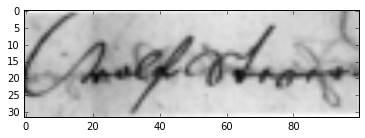

In [100]:
from skimage.color import gray2rgb, rgb2gray
#print(gray2rgb(image_reshape).shape)
#imgplot = plt.imshow(image_reshape)
plt.imshow(image_reshape, cmap='gray')

In [ ]:
skimage.color.gray2rgb(image, alpha=None)

###### So, I can print a grey-scale image of any tensor in this project. So I will load all images in a validation run in a list, together with predictions and ground truth as well as word and error rates. Then I can find word and character rates that I want to display, and i can graph accordingly.

The following files at fastai can help me with graphing things how I want to:

https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py

https://github.com/fastai/courses/blob/master/deeplearning2/utils2.py


TypeError: list indices must be integers, not tuple

In [16]:
def to_grayscale(img):
    image_reshape = np.swapaxes(img, 0, 2)
    image_reshape = np.swapaxes(image_reshape, 0, 1)
    image_reshape = np.squeeze(image_reshape)
    return(image_reshape)

def val(net, dataset, criterion, max_iter=100):
    print('Start val')

    for p in crnn.parameters():
        p.requires_grad = False

    net.eval()
    data_loader = torch.utils.data.DataLoader(
        dataset, shuffle=True, batch_size=batchSize, num_workers=int(workers))
    val_iter = iter(data_loader)

    i = 0
    n_correct = 0
    loss_avg = utils.averager()
    
    image_count = 0
    
    
    
    # Character and word error rate lists
    char_error = []
    w_error = []
    
    # Lists of images, predictions and ground truth to correlate with character and word error rates
    image_list = []
    pred_list = []
    gt_list = []
    
    

    max_iter = min(max_iter, len(data_loader))
    #max_iter = len(data_loader)
    for i in range(max_iter):
        data = val_iter.next()
        i += 1
        cpu_images, cpu_texts = data
        batch_size = cpu_images.size(0)
        image_count = image_count + batch_size
        utils.loadData(image, cpu_images)
        t, l = converter.encode(cpu_texts)
        utils.loadData(text, t)
        utils.loadData(length, l)

        preds = crnn(image)
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        cost = criterion(preds, text, preds_size, length) / batch_size
        loss_avg.add(cost)
        
        
        # RA: While I am not sure yet, it looks like a greedy decoder and not beam search is being used here
        # Also, a simple character by character accuracy is being used, not an edit distance.
        # Case is ignored in the accuracy, which is not ideal for an actual working system
        
        _, preds = preds.max(2)
        preds = preds.squeeze(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
        for pred, target, img in zip(sim_preds, cpu_texts, cpu_images.numpy()):
            if pred == target.lower():
                n_correct += 1
            #print(pred)
            #print("Pred: %s; target: %s" % (pred, target))
            char_error.append(cer(pred, target.lower()))
            w_error.append(wer(pred, target.lower()))
            image_list.append(to_grayscale(img))
            pred_list.append(pred)
            gt_list.append(target)

    raw_preds = converter.decode(preds.data, preds_size.data, raw=True)[:n_test_disp]
    for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

    accuracy = n_correct / float(max_iter * batchSize)
    print('Test loss: %f, accuracy: %f' % (loss_avg.val(), accuracy))
    
    char_arr =np.array(char_error)
    w_arr = np.array(w_error)
    #numpy.std(arr, ddof=1)
    #numpy.mean(arr, axis=0)
    #print("All character error rates:")
    #print(char_error)
    #print("All word error rates")
    #print(w_error)
    print("Character error rate mean: %4.4f; Character error rate sd: %4.4f" % (np.mean(char_arr), np.std(char_arr, ddof=1)))
    print("Word error rate mean: %4.4f; Word error rate sd: %4.4f" % (np.mean(w_arr), np.std(w_arr, ddof=1)))
    print("Total number of images in validation set: %8d" % image_count)
    return (char_error, w_error, image_list, pred_list, gt_list)

In [39]:
char_error, w_error, all_images, all_preds, all_gts = val(crnn, training_eval_set, criterion)

Start val
jer-�rrrrgetgge dd. diesen => jer�rgetge d. diesen, gt: heisen Hōrwarter. vnd Geörgen
waaf-ffner. jeronimūsseen => waffner. jeronimūsen, gt: Waffner. Jeronimūsen
aandan gnddtzggghennddanen => andan gndtzghendanen, gt: vnd vermigend firgesehen, ūnnd wann
m----eee-----zzggg----eerr => mezger              , gt: Mezger              
vor herrnssattt vnndlvnndd => vor hernsat vndlvnd , gt: vor herrn Statt: vnd Lanndt¬
zūegeschickht wwerrdden.  => zūegeschickht werden. , gt: Zūegeschickht werden. 
f-------�ūnf--f-teeennn.. => fūnfften.          , gt: Fūnfften.          
prrzeen zognsilt  wwrdeen. => przen zognsilt wrden., gt: Prūgger Zūegstelt werden. 
iin-geeedenn--ckhhh sein.  => ingedenckh sein.    , gt: Ingedenckh sein.    
aab -rpirr tcitver tneczal => ab rpir tcitver tneczal, gt: Aūf der Nachberschafft Zū
br-las wal  iiezzm-w-mnnid => brlas wal iezmwmnid , gt: haltet umb die Inwonnūng 
maarrrtin pircher.. graff. => martin pircher. graf., gt: Martin Pircher. Graf.
berfinf er br

In [18]:
#https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [36]:
1023/2

511

In [37]:
def plots_extreme(char_err, w_err, images, preds, gts, n=5, err="char", best=True, median=False):
    # Fixing random state for reproducibility
    np.random.seed(19680801)

    # Ascending sort
    to_sort = None
    if err=="char":
        to_sort = char_err
    elif err == "word":
        to_sort = w_err
    elif err == "both":
        to_sort = [j/2 for j in (char_err + w_err)]
    s_idxs = [i[0] for i in sorted(enumerate(to_sort), key=lambda x:x[1], reverse = False if best else True)]
    s_char_err = [char_err[i] for i in s_idxs]
    s_w_err = [w_err[i] for i in s_idxs]
    s_images = [images[i] for i in s_idxs]
    s_preds = [preds[i] for i in s_idxs]
    s_gts = [gts[i] for i in s_idxs]
    
    titles = ["Prediction: %-20s\nGround Truth: %-20s" % (pred, gt) for pred, gt in zip(s_preds, s_gts)]
    #for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        #print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

    print("Got through all the sorting in plots_best")
    if median:
        show_images(s_images[len(s_images)/2:len(s_images)/2+5], cols=5, titles=titles[len(s_images)/2:len(s_images)/2+5])
    else:
        show_images(s_images[0:n], cols=5, titles=titles[0:n])   
    return(1)
    
    
    # Need to give show images all correct order

In [133]:
sorts = np.argsort(char_error)

sortes = [i[0] for i in sorted(enumerate(char_error), key=lambda x:x[1], reverse=True)]
#for idx in sorts:
#    print(char_error[sorts])

In [134]:
for i in sortes:
    print(char_error[i])
    

10.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
3.0
3.0
3.0
3.0
3.0
2.66666666667
2.5
2.5
2.5
2.5
2.46153846154
2.45454545455
2.33333333333
2.0
2.0
2.0
2.0
2.0
2.0
2.0
1.84615384615
1.81818181818
1.61538461538
1.6
1.57142857143
1.53846153846
1.53333333333
1.5
1.5
1.5
1.46153846154
1.46153846154
1.45
1.42857142857
1.41176470588
1.4
1.38888888889
1.38888888889
1.38888888889
1.38461538462
1.375
1.375
1.35294117647
1.35294117647
1.33333333333
1.33333333333
1.33333333333
1.33333333333
1.33333333333
1.33333333333
1.33333333333
1.3125
1.3125
1.3125
1.3125
1.3
1.29411764706
1.28571428571
1.28571428571
1.28571428571
1.27272727273
1.27272727273
1.26315789474
1.25
1.25
1.2380952381
1.2380952381
1.23529411765
1.23076923077
1.22222222222
1.21052631579
1.2
1.2
1.2
1.2
1.2
1.19047619048
1.17647058824
1.17647058824
1.17647058824
1.16666666667
1.16666666667
1.16666666667
1.15
1.15
1.14285714286
1.14285714286
1.14285714286
1.14285714286
1.13636363636
1.125
1.125
1.125
1.125
1.11764705882
1.11764705882
1.1111111111

In [1]:
[j/2 for j in (w_error + char_error)]

NameError: name 'w_error' is not defined

(array([   1.,    0.,    3.,   29.,    2.,  651.,  136.,   88.,   30.,   61.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

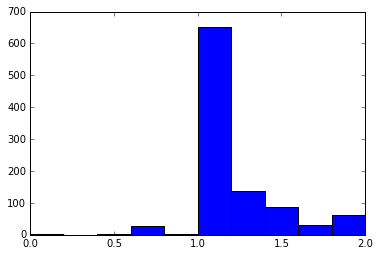

In [129]:
plt.hist(w_error, range=(0, 2), bins=10)

In [25]:
char_error[0:5]

[0.84, 0.9047619047619048, 0.0, 0.0, 0.0]

Got through all the sorting in plots_best


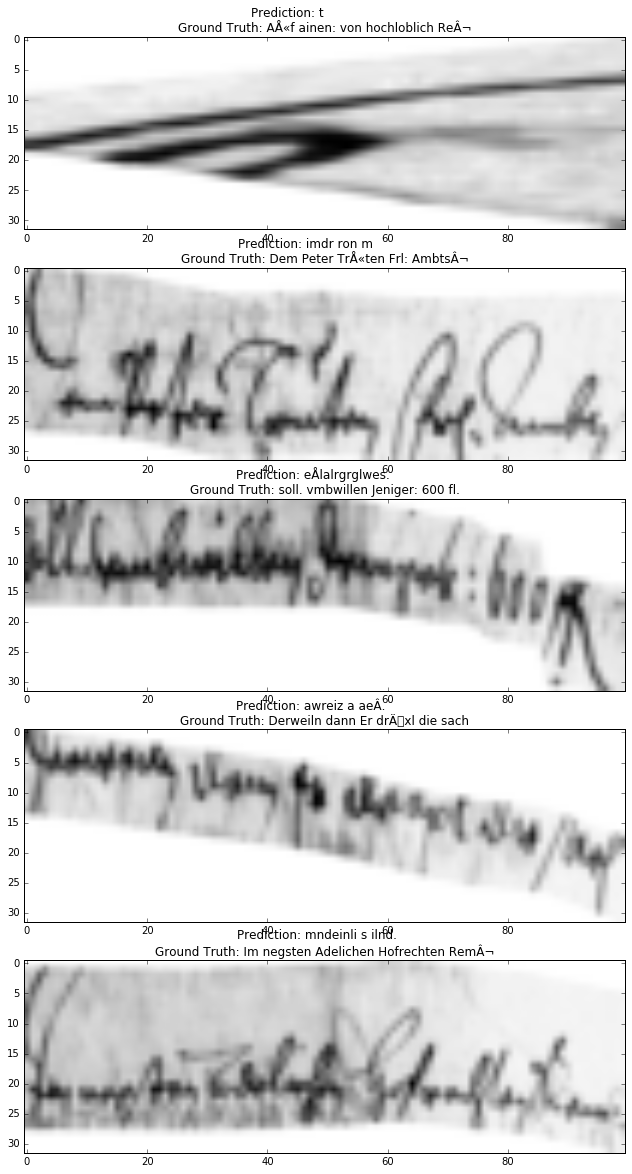

1

In [31]:
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=False)  # maybe a both char and word too using a linear combination
#plots_average()   # plots around the average I really just need to sort indices
#plots_worst

In [33]:
char_error, w_error, all_images, all_preds, all_gts = val(crnn, test_dataset, criterion)

Start val
han---dt on-n pand-st aa-. => handt onn pandst a. , gt: hanns Bernhardt von 
pae--- ------m---eeetpad-n => pae metpadn         , gt: Zesein. Damit man mit Ime 
dan-eeg  fribblssindizen-. => daneg friblsindizen., gt: Geörg Prackh seliger
se-lben taie per--n-ndden. => selben taie pernnden., gt: sollen die Prenndten
------------------------21 => 21                  , gt: bet:                
der loggeen ben e  ohen--n => der logen ben e ohenn, gt: der Kirchen bei S: Johannes
lan- �mm-- eeddl- graai-n. => lan �m edl grain.   , gt: beclagen. das: wann 
liien aūspign  dn  ww-lh� => lien aūspign dn wlh�, gt: lesen. Aūch Inen den viertl¬
lem--ngaarr  an--ee. bea¬ => lemngar ane. bea¬  , gt: Pennzinger. hannsen Loche¬
dam-nntaūl ma- iee leiis. => damntaūl ma ie leis., gt: Lanndthaūbtman Ime Koler
sezpee-ndd. vddladderonin. => sezpend. vdladeronin., gt: als Pferdt. vnd ander Vieh
--------111-------------77 => 17                  , gt: 178                 
mid -m--eerigg  e gaddmme  => 

Got through all the sorting in plots_best


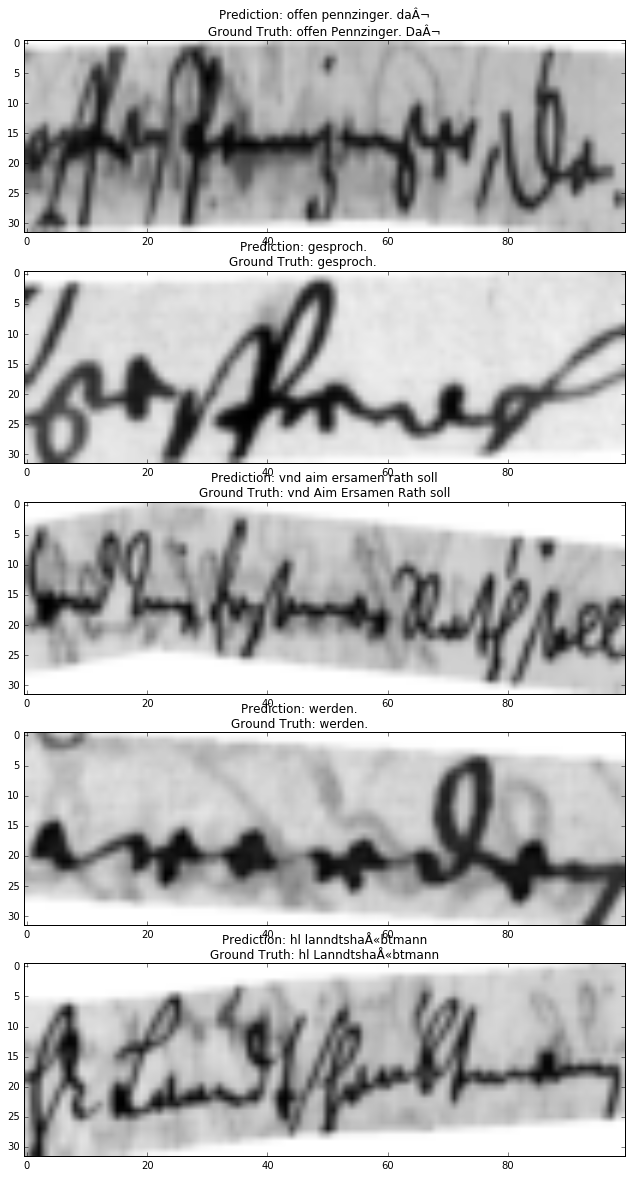

1

In [40]:
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=True) 

In [51]:
utils.loadData(image, cpu_images)
t, l = converter.encode(cpu_texts)
utils.loadData(text, t)
utils.loadData(length, l)

In [ ]:
preds = crnn(image)
preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
cost = criterion(preds, text, preds_size, length) / batch_size
loss_avg.add(cost)


# RA: While I am not sure yet, it looks like a greedy decoder and not beam search is being used here
# Also, a simple character by character accuracy is being used, not an edit distance.
# Case is ignored in the accuracy, which is not ideal for an actual working system

_, preds = preds.max(2)
preds = preds.squeeze(2)
preds = preds.transpose(1, 0).contiguous().view(-1)
sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
for pred, target in zip(sim_preds, cpu_texts):
    if pred == target.lower():
        n_correct += 1
    #print(pred)
    #print("Pred: %s; target: %s" % (pred, target))
    char_error.append(cer(pred, target.lower()))
    w_error.append(wer(pred, target.lower()))

raw_preds = converter.decode(preds.data, preds_size.data, raw=True)[:n_test_disp]
for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

accuracy = n_correct / float(max_iter * batchSize)
print('Test loss: %f, accuracy: %f' % (loss_avg.val(), accuracy))

char_arr =np.array(char_error)
w_arr = np.array(w_error)
#numpy.std(arr, ddof=1)
#numpy.mean(arr, axis=0)
#print("All character error rates:")
#print(char_error)
#print("All word error rates")
#print(w_error)
print("Character error rate mean: %4.4f; Character error rate sd: %4.4f" % (np.mean(char_arr), np.std(char_arr, ddof=1)))
print("Word error rate mean: %4.4f; Word error rate sd: %4.4f" % (np.mean(w_arr), np.std(w_arr, ddof=1)))
print("Total number of images in validation set: %8d" % image_count)
return (char_error, w_error)